In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# M1 L2/3

In [2]:
with open('python/methods.py', 'r') as file:
    exec(file.read())

In [3]:
samples = pd.read_csv('sample_sheet.csv')
samples = samples[ samples['Region'] == 'M1_L23' ]
samples

,SID,AnimalID,CellName,Region,Date,Depth,Count,Location
20,W1_C3,W1,C3,M1_L23,2019 12 09,305.290403,310,W1/C3
21,W1_C4,W1,C4,M1_L23,2019 12 09,374.226946,380,W1/C4
22,W1_C5,W1,C5,M1_L23,2019 12 09,216.657706,220,W1/C5
23,W1_C6,W1,C6,M1_L23,2019 12 09,305.290403,310,W1/C6
24,W2_C1,W2,C1,M1_L23,2019 12 12,142.797124,145,W2/C1
25,W2_C2,W2,C2,M1_L23,2019 12 12,315.138481,320,W2/C2
26,W3_C1,W3,C1,M1_L23,2019 12 17,374.226946,380,W3/C1
27,W3_C2,W3,C2,M1_L23,2019 12 17,157.569240,160,W3/C2
28,W3_C3,W3,C3,M1_L23,2019 12 17,384.075024,390,W3/C3
29,W3_C7,W3,C7,M1_L23,2019 12 17,315.138481,320,W3/C7


In [4]:
def read_sample_event_data(sample_name, movement = True, time_shift = 0, event_length = 0.25):
    """
    Reads sample event data.
    
    :param sample_name: Sample identifier.
    :param movement: Whether to read movement or no movement data.
    :param time_shift: How much time to record before the event (negative shift) or after the event
                       (positive shift) (in seconds). If the shift is not possible, will return
                       zero-padded values.
    :param event_length: How much of the event time to return (in seconds). None corresponds to the
                         complete event.
    :return: np.array (number of events x time points)
    """
    import re
    import numpy as np

    animal_id = re.match('(W[0-9]+).*', sample_name).group(1)
    cell_name = re.match('.*(C[0-9]+)', sample_name).group(1)
    
    prefix = f'output/spontaneous-movement/{animal_id}/{cell_name}/'
    
    sample_data = read_pickle(f'{prefix}/vm/filter.pkl')
    
    if movement:
        sample_events = read_pickle(f'{prefix}/emg/filtered_movement_events.pkl')
    else:
        sample_events = read_pickle(f'{prefix}/emg/no_movement_events.pkl')

    before_event = time_shift < 0
    time_shift = np.abs(time_shift)
    
    n_expected_points = sample_data.info['sfreq'] * (time_shift + event_length) + 1

    event_data = []
    for i, event in sample_events.iterrows():
        if before_event:
            start = event['Start'] - time_shift
            start = np.max([start, np.min(sample_data.times)])
            end = event['Start'] + event_length
        else:
            start = event['End'] - event_length
            end = event['End'] + time_shift
            end = np.min([end, np.max(sample_data.times)])

        channel = event['ChannelId']

        channel_data = sample_data.copy().crop(tmin = start, tmax = end).get_data(picks = [channel]).flatten()

        # If the time shift was not possible, will have to append a few points here and there
        if len(channel_data) < n_expected_points:
            print('Too short')
            average = np.mean(channel_data)
            append = np.ones(int(n_expected_points - len(channel_data)))
            append = append * average
            
            assert len(append) + len(channel_data) == n_expected_points
            
            if before_event:
                channel_data = np.concatenate([append, channel_data])
            else:
                channel_data = np.concatenate([channel_data, append])

        event_data.append(channel_data)

    event_data = np.array(event_data)
    
    return event_data

In [5]:
def read_event_data(sample_ids, movement = True, time_shift = 0, event_length = 0.25):
    event_data = []
    for sample_id in sample_ids:
        event_data.append(read_sample_event_data(sample_id, movement = movement, time_shift = time_shift, event_length = event_length))
    
    event_data = np.concatenate(event_data)
    return event_data

In [6]:
event_data_before = read_event_data(sample_ids = samples['SID'], time_shift = -0.25, event_length = 0.5)

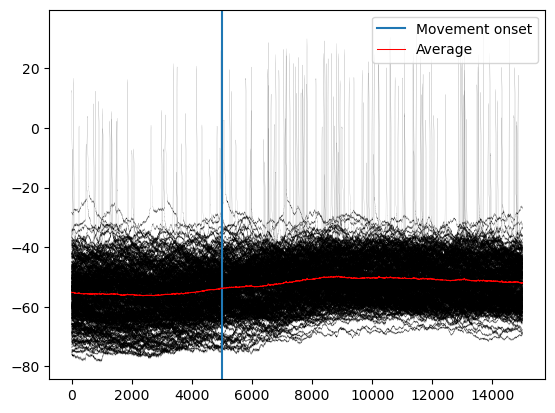

In [7]:
for i in event_data_before:
    plt.plot(i, linewidth = 0.05, color = 'black')

plt.axvline(x = 0.25 * 20000, label = 'Movement onset')
plt.plot(np.mean(event_data_before, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

In [8]:
onset_idx = int(0.25 * 20000)
print(f'Average signal before the event: {np.mean(event_data_before[ :, :onset_idx ])}')
print(f'Average signal during the event: {np.mean(event_data_before[ :, onset_idx: ])}')

Average signal before the event: -55.51390166279421
Average signal during the event: -51.237473360385295


In [9]:
event_data_after = read_event_data(sample_ids = samples['SID'], time_shift = 0.25, event_length = 0.5)

Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short
Too short


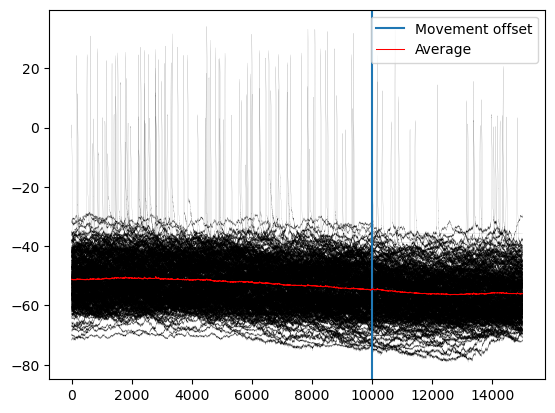

In [10]:
for i in event_data_after:
    plt.plot(i, linewidth = 0.05, color = 'black')
    
plt.axvline(x = 0.5 * 20000, label = 'Movement offset')
plt.plot(np.mean(event_data_after, axis = 0), linewidth = 0.75, color = 'red', label = 'Average')
plt.legend(loc = 'upper right')
plt.show()

In [11]:
offset_idx = int(0.5 * 20000)
print(f'Average signal during the event: {np.mean(event_data_after[ :, :offset_idx ])}')
print(f'Average signal after the event: {np.mean(event_data_after[ :, offset_idx: ])}')

Average signal during the event: -52.14474900165016
Average signal after the event: -55.80589156367472


In [12]:
data_before = event_data_before[ :, :onset_idx ]
data_during_early = event_data_before[ :, onset_idx: ]
data_during_late = event_data_after[ :, :offset_idx ]
data_after = event_data_after[ :, offset_idx: ]

In [13]:
dt = np.concatenate([
    np.mean(data_before, axis = 1),
    np.mean(data_during_early, axis = 1),
    np.mean(data_during_late, axis = 1),
    np.mean(data_after, axis = 1)
])

types = np.concatenate([
    np.repeat('Before', data_before.shape[0]),
    np.repeat('Early event', data_during_early.shape[0]),
    np.repeat('Late event', data_during_late.shape[0]),
    np.repeat('After', data_after.shape[0])
])

assert len(dt) == len(types)

dt = pd.DataFrame({
    'Median': dt,
    'Type': types
})

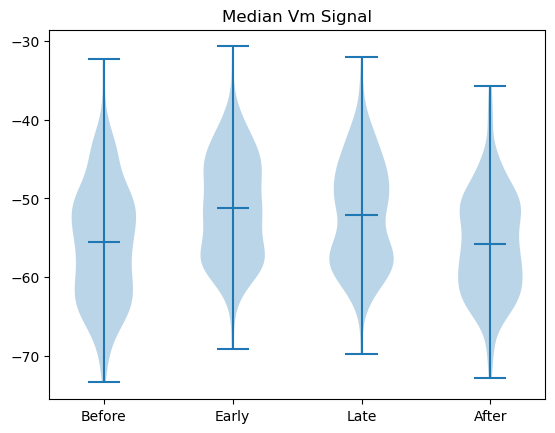

In [14]:
plt.violinplot([
    dt[dt['Type'] == 'Before']['Median'],
    dt[dt['Type'] == 'Early event']['Median'],
    dt[dt['Type'] == 'Late event']['Median'],
    dt[dt['Type'] == 'After']['Median']
], showmeans = True)

plt.xticks([1, 2, 3, 4], ['Before', 'Early', 'Late', 'After'])
plt.title('Median Vm Signal')
plt.show()

In [15]:
dt1 = dt[dt['Type'] == 'Before']['Median']
dt2 = dt[dt['Type'] == 'Early event']['Median']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: -7.129811383554063
P-value: 3.0462681736851793e-12


Slight difference between before the event and during the event.

In [16]:
dt1 = dt[dt['Type'] == 'Early event']['Median']
dt2 = dt[dt['Type'] == 'Late event']['Median']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 1.6132401710963669
P-value: 0.10724386269610119


No difference between the start of event versus the end of event.

In [17]:
dt1 = dt[dt['Type'] == 'Late event']['Median']
dt2 = dt[dt['Type'] == 'After']['Median']
t_statistic, p_value = ttest_ind(dt1, dt2)
print('T-statistic:', t_statistic)
print('P-value:', p_value)

T-statistic: 6.512718427050078
P-value: 1.6178585507845884e-10


Slight difference between during the event and after the event.